<a href="https://colab.research.google.com/github/RaedAbdelkefi/Facial-Expression-Recognition/blob/main/facinal_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import SeparableConv2D
from keras.optimizers import Adam
from keras import layers
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator


#Loading the Data

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 97% 276M/285M [00:01<00:00, 205MB/s]
100% 285M/285M [00:01<00:00, 157MB/s]


In [ ]:
!unzip "/content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip"

Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


#Dataset Overview

In [ ]:
df = pd.read_csv('icml_face_data.csv')

In [ ]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
emotion_num_map={0:'angry', 1:'disgusted', 2:'affraid', 3:'happy', 4: 'sad', 5: 'surprised', 6: 'neutral'}


In [ ]:
def plot_images(df, emotion_class):

  emo_df = df[df.emotion==emotion_class]
  row = emo_df.sample(1)
  img = np.fromstring(row[' pixels'].iloc[0], dtype=int, sep=' ')
  img = np.reshape(img, (48, 48))
  image = np.zeros((48,48,3))
  image[:,:,0] = img
  image[:,:,1] = img
  image[:,:,2] = img
  image = np.array(image.astype(np.uint8))
  return image

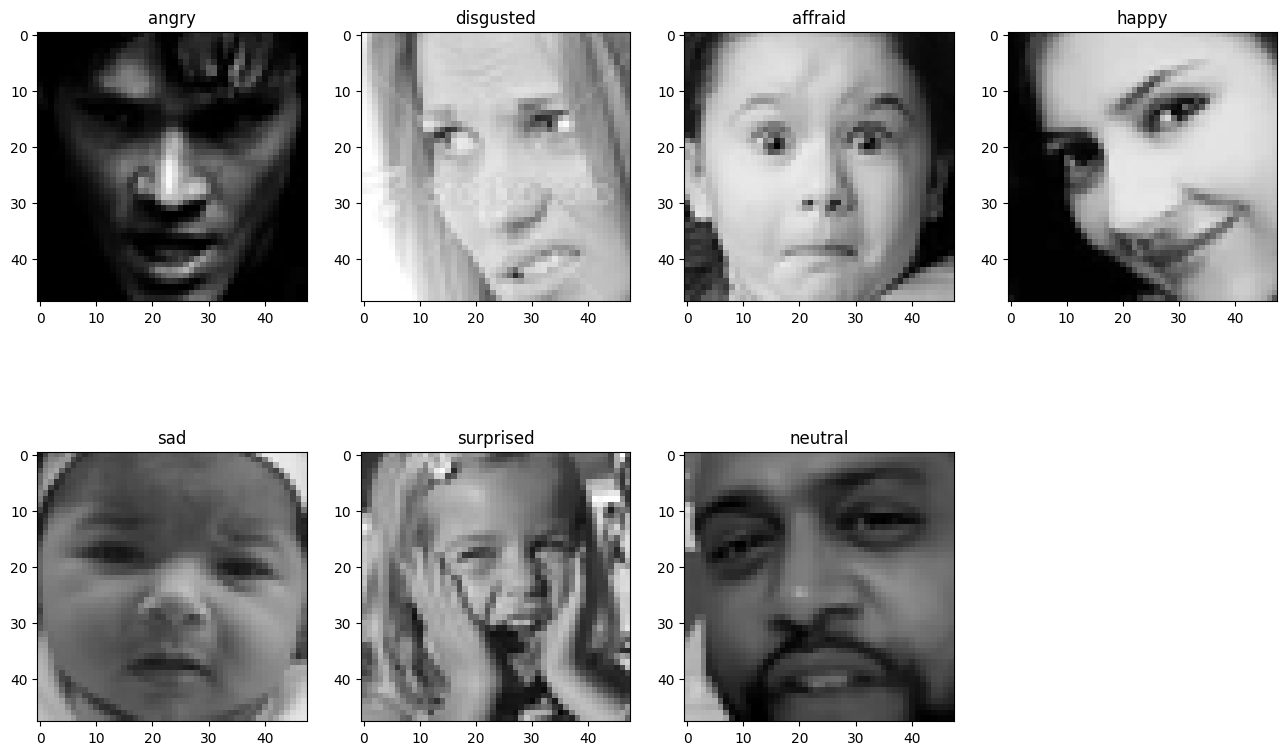

In [ ]:
plt.figure(0, figsize=(16,10))

for i in range(7):
  plt.subplot(2,4,i+1)
  image = plot_images(df,i)
  plt.imshow(image)
  plt.title( emotion_num_map[i])

#Pre-processing data

##Splitting dataset into 3 parts: train, validation, test

In [ ]:
data_train = df[df[' Usage']=='Training'].copy()
data_val   = df[df[' Usage']=='PublicTest'].copy()
data_test  = df[df[' Usage']=='PrivateTest'].copy()
data_test

,emotion,Usage,pixels
32298,0,PrivateTest,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
32299,5,PrivateTest,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
32300,6,PrivateTest,232 240 241 239 237 235 246 117 24 24 22 13 12...
32301,4,PrivateTest,200 197 149 139 156 89 111 58 62 95 113 117 11...
32302,2,PrivateTest,40 28 33 56 45 33 31 78 152 194 200 186 196 20...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


##Normalize the Data

In [ ]:
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64
def CRNO(df, dataName):
    df[' pixels'] = df[' pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df[' pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


#Building CNN Model

In [ ]:
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64
len(train_X)

28709

In [ ]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

In [ ]:

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=49,
                                verbose=2,
                                validation_data=(val_X, val_Y))


Epoch 1/49
448/448 - 60s - loss: 1.6982 - accuracy: 0.3220 - val_loss: 2.1328 - val_accuracy: 0.2839 - 60s/epoch - 135ms/step
Epoch 2/49
448/448 - 43s - loss: 1.3972 - accuracy: 0.4577 - val_loss: 1.6022 - val_accuracy: 0.4154 - 43s/epoch - 96ms/step
Epoch 3/49
448/448 - 43s - loss: 1.2577 - accuracy: 0.5186 - val_loss: 1.3696 - val_accuracy: 0.4879 - 43s/epoch - 95ms/step
Epoch 4/49
448/448 - 43s - loss: 1.1804 - accuracy: 0.5510 - val_loss: 1.3235 - val_accuracy: 0.5071 - 43s/epoch - 97ms/step
Epoch 5/49
448/448 - 44s - loss: 1.1342 - accuracy: 0.5670 - val_loss: 1.2820 - val_accuracy: 0.5163 - 44s/epoch - 97ms/step
Epoch 6/49
448/448 - 44s - loss: 1.0882 - accuracy: 0.5854 - val_loss: 1.1485 - val_accuracy: 0.5626 - 44s/epoch - 98ms/step
Epoch 7/49
448/448 - 44s - loss: 1.0567 - accuracy: 0.5992 - val_loss: 1.1592 - val_accuracy: 0.5637 - 44s/epoch - 98ms/step
Epoch 8/49
448/448 - 44s - loss: 1.0334 - accuracy: 0.6070 - val_loss: 1.1062 - val_accuracy: 0.5879 - 44s/epoch - 97ms/step

#Evaluate Test Performance

In [ ]:
loss, accuracy = model.evaluate(data_generator.flow(test_X, test_Y, batch_size))

57/57 [==============================] - 2s 35ms/step - loss: 1.1138 - accuracy: 0.6428


In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 2s 14ms/step
CNN Model Accuracy on test set: 0.6732


#Visualize Training Performance

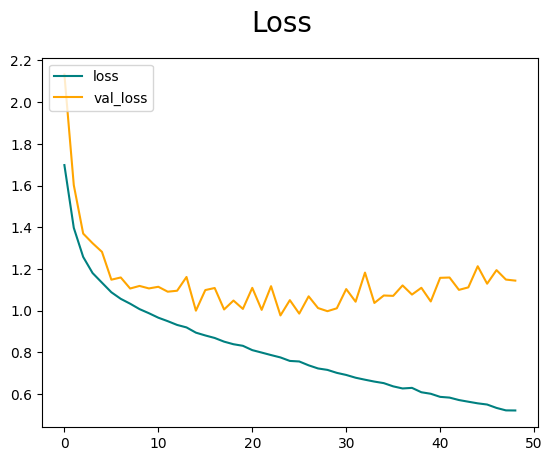

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

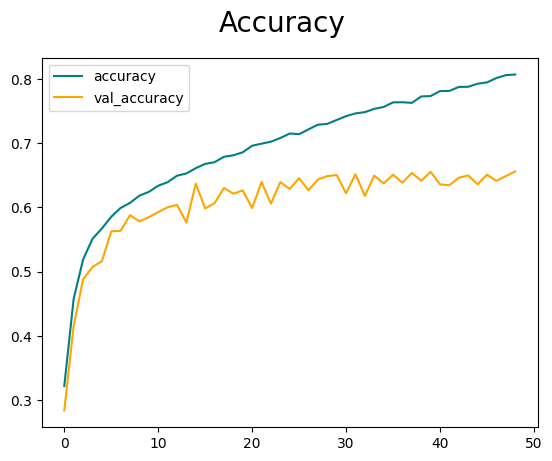

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

def _predict(path):
  facecasc = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
  imagePath = path
  image = cv2.imread(imagePath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=10)
  if len(faces)==0:
    print("No faces : ",len(faces))
  i = 1
  for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]                      #croping
    roi_gray=roi_gray/255.
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    prediction = model.predict(cropped_img)

    maxindex = int(np.argmax(prediction))
    print("person ",i," : ",emotion_num_map[maxindex])
    cv2.putText(image, emotion_num_map[maxindex], (x+10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                                              #if text is not apeared , change coordinates. it may work
    i+=1

  cv2_imshow(image)

#Testing the model

1/1 [==============================] - 1s 862ms/step
person  1  :  angry


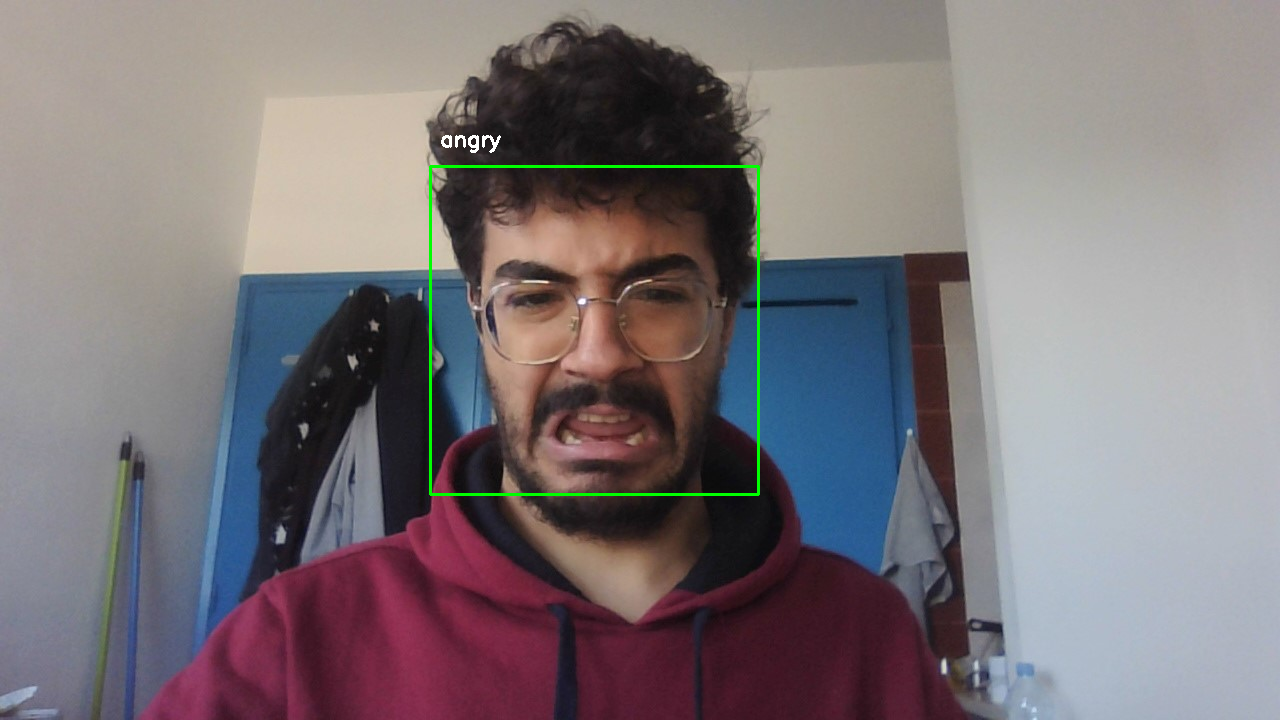

In [ ]:
imgpath='/content/WIN_20230426_07_31_55_Pro.jpg'
_predict(imgpath)

1/1 [==============================] - 0s 53ms/step
person  1  :  neutral


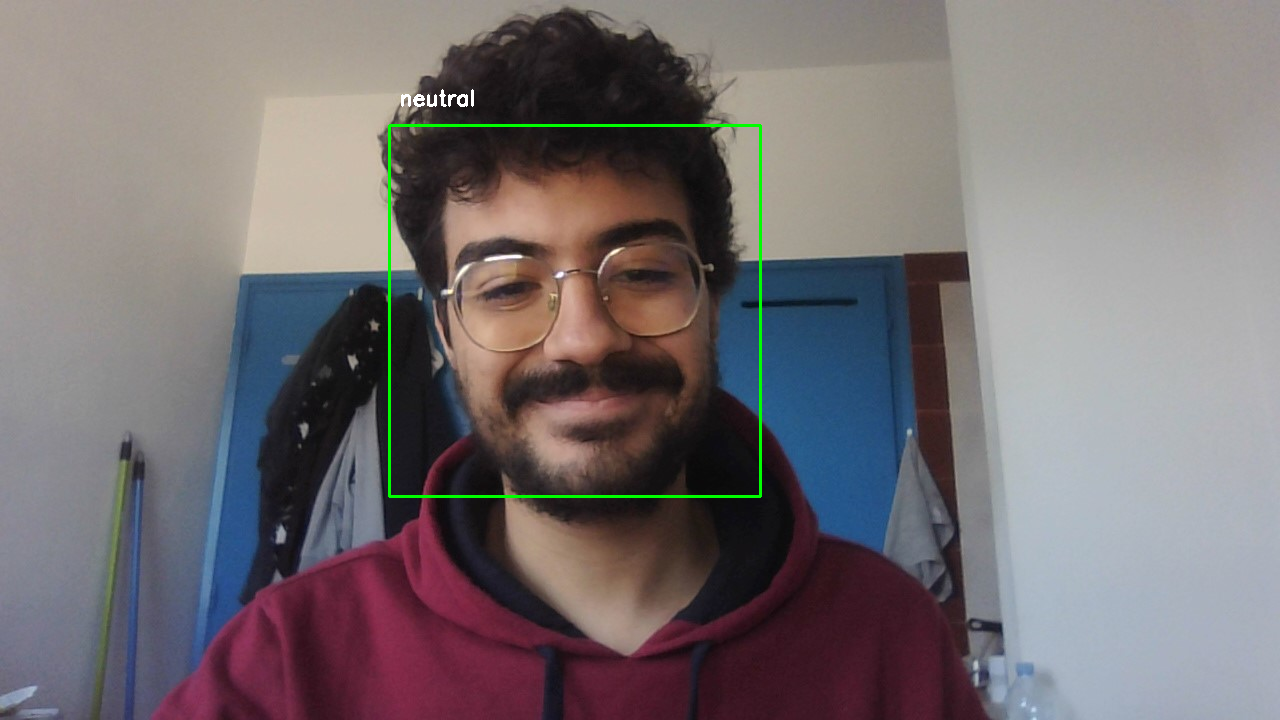

In [ ]:
imgpath='/content/WIN_20230426_07_31_16_Pro.jpg'
_predict(imgpath)

1/1 [==============================] - 0s 73ms/step
person  1  :  happy


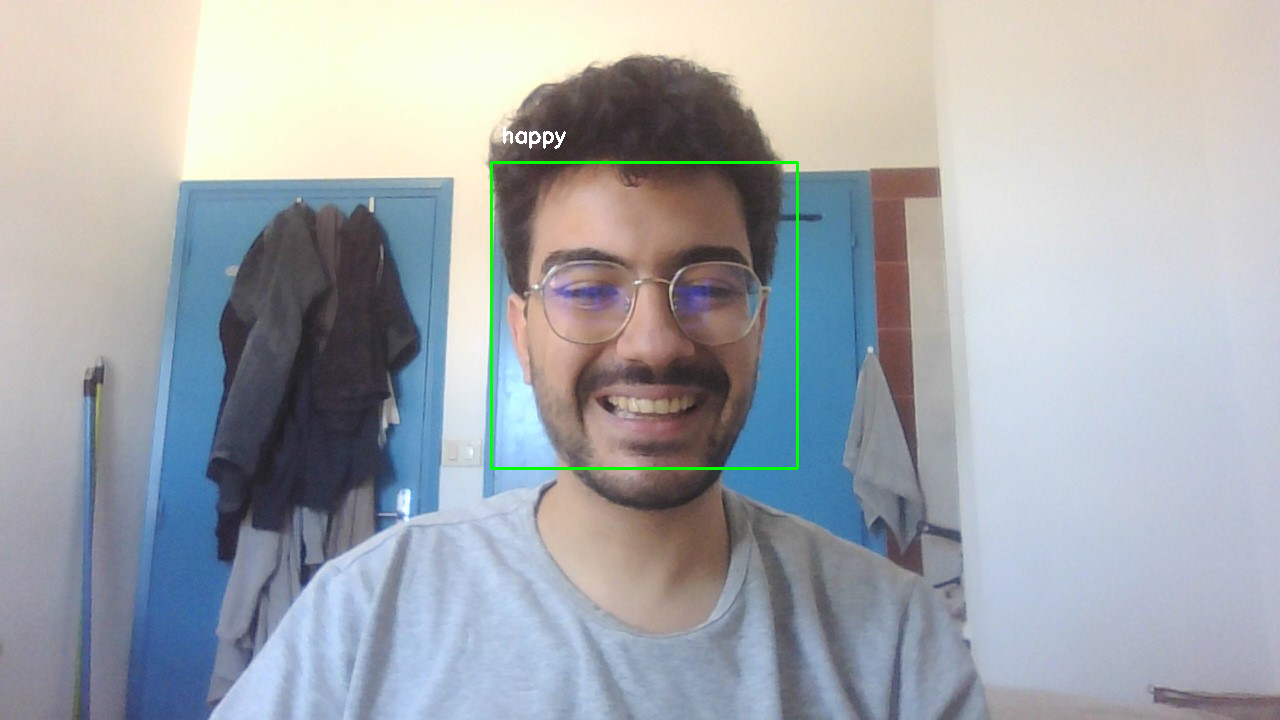

In [ ]:
imgpath='/content/WIN_20230504_11_21_23_Pro.jpg'
_predict(imgpath)

#Saving the model

In [ ]:
# model.save('model.h5')


In [ ]:
from google.colab import files
files.download('model.h5')

In [ ]:
from keras.models import load_model
model = load_model('model.h5')

In [ ]:
!jupyter nbconvert --to html '/content/facinal_expression_recognition (1).ipynb'


[NbConvertApp] Converting notebook /content/facinal_expression_recognition (1).ipynb to html
[NbConvertApp] Writing 3876804 bytes to /content/facinal_expression_recognition (1).html


In [ ]:
/content/facinal_expression_recognition (1).ipynb